For the implementation of the method relying on LLMs, such as Llama or Qwen, we used the template provided by Unsloth (https://huggingface.co/unsloth), which is a resource-efficient implementation suited for our task.




To run this, press "*Runtime*" and press "*Run all*" on a **free** Tesla T4 Google Colab instance!
<div class="align-center">
  <a href="https://github.com/unslothai/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/u54VK8m8tk"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord button.png" width="145"></a>
  <a href="https://ko-fi.com/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Kofi button.png" width="145"></a></a> Join Discord if you need help + support us if you can!
</div>

To install Unsloth on your own computer, follow the installation instructions on our Github page [here](https://github.com/unslothai/unsloth#installation-instructions---conda).

You will learn how to do [data prep](#Data), how to [train](#Train), how to [run the model](#Inference), & [how to save it](#Save) (eg for Llama.cpp).

In [1]:
import torch
major_version, minor_version = torch.cuda.get_device_capability()

# %%
import os
import pandas as pd
import numpy as np
# os.environ["WANDB_DISABLED"] = "true"

# %%
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+


# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/mistral-7b-bnb-4bit",
    "unsloth/mistral-7b-instruct-v0.1-bnb-4bit",
    "unsloth/mistral-7b-instruct-v0.2-bnb-4bit",
    "unsloth/llama-2-7b-bnb-4bit",
    "unsloth/llama-2-13b-bnb-4bit",
    "unsloth/codellama-34b-bnb-4bit",
    "unsloth/tinyllama-bnb-4bit",
]


# As our base, we use Qwen2 7B model
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Qwen2-7B-bnb-4bit",
    # model_name = "unsloth/tinyllama-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = True,

)



🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


config.json:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

==((====))==  Unsloth: Fast Qwen2 patching release 2024.6
   \\   /|    GPU: NVIDIA RTX 4000 Ada Generation. Max memory: 19.681 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.1+cu118. CUDA = 8.9. CUDA Toolkit = 11.8.
\        /    Bfloat16 = TRUE. Xformers = 0.0.26.post1+cu118. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


model.safetensors:   0%|          | 0.00/5.55G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/117 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/80.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/370 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
unsloth/Qwen2-7B-bnb-4bit does not have a padding token! Will use pad_token = <|PAD_TOKEN|>.


* We support Llama, Mistral, CodeLlama, TinyLlama, Vicuna, Open Hermes etc
* And Yi, Qwen ([llamafied](https://huggingface.co/models?sort=trending&search=qwen+llama)), Deepseek, all Llama, Mistral derived archs.
* We support 16bit LoRA or 4bit QLoRA. Both 2x faster.
* `max_seq_length` can be set to anything, since we do automatic RoPE Scaling via [kaiokendev's](https://kaiokendev.github.io/til) method.
* [**NEW**] With [PR 26037](https://github.com/huggingface/transformers/pull/26037), we support downloading 4bit models **4x faster**! [Our repo](https://huggingface.co/unsloth) has Llama, Mistral 4bit models.

We now add LoRA adapters so we only need to update 1 to 10% of all parameters!

In [2]:
# In our approach we tested both with and without LoRA

# import torch
# import torch.nn as nn
# from peft.tuners.lora import LoraLayer

# def new_reset_lora_parameters(self, adapter_name, init_lora_weights):
#     if init_lora_weights is False:
#         return

#     if adapter_name in self.lora_A.keys():
#         if init_lora_weights is True:
#             with torch.no_grad():
#                 # Method 1: QR decomposition of a random matrix
#                 print(f"Initializing {adapter_name} with QR decomposition of a random matrix")
#                 r = self.r[adapter_name]
#                 m = self.in_features
#                 n = self.out_features
#                 X = torch.randn(r, r)
#                 Q, _ = torch.linalg.qr(X)
#                 set1 = Q[0::2, :]  # Odd rows
#                 set2 = Q[1::2, :]  # Even rows
#                 a_wt = torch.randn(m, r // 2).mm(set1).to(torch.bfloat16).T / 50.0
#                 b_wt = torch.randn(r // 2, n).T.mm(set2).to(torch.bfloat16) / 50.0


#                 self.lora_A[adapter_name].weight = nn.Parameter(a_wt.contiguous())
#                 self.lora_B[adapter_name].weight = nn.Parameter(b_wt.contiguous())
#         elif init_lora_weights.lower() == "gaussian":
#             nn.init.normal_(self.lora_A[adapter_name].weight, std=1 / self.r[adapter_name])
#             nn.init.zeros_(self.lora_B[adapter_name].weight)
#         else:
#             raise ValueError(f"Unknown initialization {init_lora_weights=}")
#     if adapter_name in self.lora_embedding_A.keys():
#         # initialize a the same way as the default for nn.linear and b to zero
#         nn.init.zeros_(self.lora_embedding_A[adapter_name])
#         nn.init.normal_(self.lora_embedding_B[adapter_name])

# # Monkey patch the method
# LoraLayer.reset_lora_parameters = new_reset_lora_parameters

In [2]:
from peft import LoftQConfig
model = FastLanguageModel.get_peft_model(
    model,
    r = 32, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = [
        # "lm_head",
        "q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
    use_rslora = True,  # We support rank stabilized LoRA
    # init_lora_weights = 'loftq',
    # loftq_config = LoftQConfig(loftq_bits = 4, loftq_iter = 1), # And LoftQ
)
print("trainable parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))

Unsloth 2024.6 patched 28 layers with 0 QKV layers, 28 O layers and 28 MLP layers.


trainable parameters: 80740352


<a name="Data"></a>
### Data Prep
We now use the Alpaca dataset from [yahma](https://huggingface.co/datasets/yahma/alpaca-cleaned), which is a filtered version of 52K of the original [Alpaca dataset](https://crfm.stanford.edu/2023/03/13/alpaca.html). You can replace this code section with your own data prep.

**[NOTE]** To train only on completions (ignoring the user's input) read TRL's docs [here](https://huggingface.co/docs/trl/sft_trainer#train-on-completions-only).

**[NOTE]** Remember to add the **EOS_TOKEN** to the tokenized output!! Otherwise you'll get infinite generations!

In [3]:
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
inputs = tokenizer(
[
    "Continue the fibonnaci sequence: 1, 1, 2, 3, 5, 8"
], return_tensors = "pt").to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128)

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Continue the fibonnaci sequence: 1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 578, 927, 1499, 2427, 3927, 6355, 10282, 16637, 26919, 43556, 70475, 114031, 184486, 298517


In [ ]:
FastLanguageModel.for_inference(model)
from transformers import TextStreamer

In [4]:
i = input()
inputs = tokenizer(
[
    i
], return_tensors = "pt").to("cuda")    
text_streamer = TextStreamer(tokenizer)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128)

 what is cgpt


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


what is cgpt?
CGPT (C++ Generic Programming Template) is a C++ library that provides a set of generic programming tools and templates for building efficient and reusable code. It is designed to be used in a variety of applications, including scientific computing, data analysis, and machine learning.

CGPT provides a range of features, including:

* Generic programming tools, such as templates, functors, and algorithms
* Data structures, such as arrays, vectors, and matrices
* Numerical algorithms, such as linear algebra, optimization, and statistics
* Input/output (I/O) support for reading and writing data in various formats

CGPT is


In [3]:
from datasets import load_dataset
from trl import SFTTrainer

In [4]:
# Load our tweet dataset

import pandas as pd
import numpy as np


import os
cwd = os.getcwd()
kaggle = cwd == "/kaggle/working"
input_dir = "/kaggle/input/tweets/twitter-datasets/twitter-datasets/" if kaggle else "data/twitter-datasets/twitter-datasets/"
output_dir = "/kaggle/working/" if kaggle else "data/"

In [5]:
import pandas as pd
import numpy as np

# load train_neg.txt and train_pos.txt with no delimiter
train_neg_lines = open(input_dir+'train_neg.txt').read().splitlines()
train_pos_lines = open(input_dir+'train_pos.txt').read().splitlines()

# convert them to list
train_neg = np.array(train_neg_lines)
train_pos = np.array(train_pos_lines)

# convert them to df
train_neg_df = pd.DataFrame(train_neg, columns=['text'])
train_neg_df['label'] = 0
train_pos_df = pd.DataFrame(train_pos, columns=['text'])
train_pos_df['label'] = 1

# combine train_neg_df and train_pos_df
df = pd.concat([train_neg_df, train_pos_df], ignore_index=True)
df = df.sample(frac=1,random_state=42).reset_index(drop=True)
df.to_csv(output_dir+'data.csv', index=False)
df

,text,label
0,<user> oan follow back please,1
1,<user> i still don't own a piece ( i have got ...,0
2,<user> well of course #tellmesomethingidontknow,1
3,#5words we should just be friends,0
4,"i know , i feel like i committed a crime now r...",0
...,...,...
199995,"jajajz barca are losing the game , lets go che...",1
199996,<user> pa help po lets make it trend #hbdgretc...,1
199997,<user> hope you have a good time to korea .,1
199998,good night ! ! another day tomorrow !,1


In [6]:
# Load the training and validation data

data = pd.read_csv(output_dir + "data.csv")

from sklearn.model_selection import train_test_split

# keep a subset (for testing)
data = data.sample(frac=0.05, random_state=42)

train_df, val_df = train_test_split(data, test_size=0.5, random_state=42)
# save to output_dir
train_df.to_csv(output_dir + "train.csv", index=False)

(array([ 31., 163., 289., 329., 381., 433., 362., 349., 302., 290., 399.,
        294., 309., 264., 215., 186., 123.,  97.,  56.,  39.,  38.,   6.,
         10.,   6.,   8.,   1.,   5.,   9.,   2.,   4.]),
 array([ 2. ,  4.1,  6.2,  8.3, 10.4, 12.5, 14.6, 16.7, 18.8, 20.9, 23. ,
        25.1, 27.2, 29.3, 31.4, 33.5, 35.6, 37.7, 39.8, 41.9, 44. , 46.1,
        48.2, 50.3, 52.4, 54.5, 56.6, 58.7, 60.8, 62.9, 65. ]),
 <BarContainer object of 30 artists>)

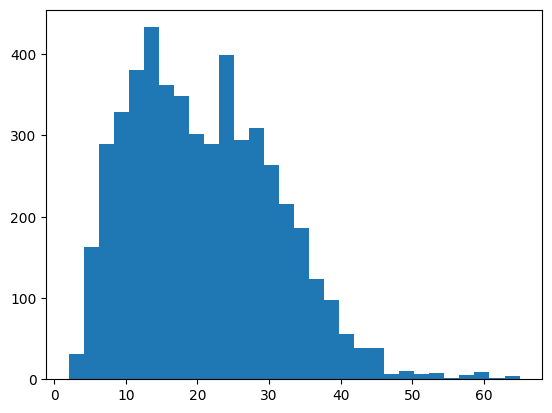

In [7]:
token_counts = [len(tokenizer.encode(x)) for x in train_df.text]
# plot the token counts
import matplotlib.pyplot as plt
plt.hist(token_counts, bins=30)

In [8]:
dataset = load_dataset(output_dir,data_files="train.csv", split="train")
dataset

Repo card metadata block was not found. Setting CardData to empty.


Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['text', 'label'],
    num_rows: 5000
})

In [9]:
# Define the prompt for the task which will be used for determining whether the tweet is positive or negative

prompt = """
In this exercise, you need to figure out what the correct emoji is at the end of a tweet.
Choice 1: "{} :)"
Choice 2: "{} :("

Which emoji do you think is the correct one?
SOLUTION
The choice with the correct emoji is: Choice {}
""".strip()




def formatting_prompts_func(dataset_):
    if isinstance(dataset_['text'], str):
        return [""]
    texts = []
    for i in range(len(dataset_['text'])):
        t = dataset_['text'][i]
        label = "1" if dataset_['label'][i] == 1 else "2"
        text = prompt.format(t,t, label)


        texts.append(text)
    return texts


response_template = "The choice with the correct emoji is: Choice "
from trl import DataCollatorForCompletionOnlyLM
collator = DataCollatorForCompletionOnlyLM(response_template, tokenizer=tokenizer)

<a name="Train"></a>
### Train the model
Now let's use Huggingface TRL's `SFTTrainer`! More docs here: [TRL SFT docs](https://huggingface.co/docs/trl/sft_trainer). We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support TRL's `DPOTrainer`!

In [10]:
from trl import SFTTrainer
from transformers import TrainingArguments

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    # dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 32,
        gradient_accumulation_steps = 1,
        warmup_steps = 5,
        # max_steps = 60,
        learning_rate = 2e-4,
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "cosine",
        seed = 3407,
        output_dir = "outputs",
        num_train_epochs = 1,
        report_to = "none",
        group_by_length = True,
    ),
    formatting_func=formatting_prompts_func,
    data_collator=collator,
)

Map (num_proc=2):   0%|          | 0/5000 [00:00<?, ? examples/s]

In [11]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA RTX 4000 Ada Generation. Max memory = 19.681 GB.
7.344 GB of memory reserved.


In [12]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 5,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 32 | Gradient Accumulation steps = 1
\        /    Total batch size = 32 | Total steps = 157
 "-____-"     Number of trainable parameters = 80,740,352


Step,Training Loss
1,0.648400
2,0.644500
3,0.503900
4,0.777300
5,0.494100
6,0.574200
7,0.500000
8,0.519500
9,0.371100
10,0.886700


In [13]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

437.5935 seconds used for training.
7.29 minutes used for training.
Peak reserved memory = 14.516 GB.
Peak reserved memory for training = 7.172 GB.
Peak reserved memory % of max memory = 73.756 %.
Peak reserved memory for training % of max memory = 36.441 %.


<a name="Inference"></a>
### Inference
Let's run the model! You can change the instruction and input - leave the output blank!

In [14]:
# alpaca_prompt = Copied from above
FastLanguageModel.for_inference(model) # Enable native 2x faster inference

In [16]:
from collections import defaultdict

# Step 1: Tokenize the inputs and sort them by their tokenized length
tokenized_inputs = []
for i in range(len(val_df['text'])):
    text = val_df['text'].iloc[i]
    test_str = prompt.format(text,text, "")
    tokenized_input = tokenizer(test_str, return_tensors="pt", add_special_tokens=False)
    tokenized_inputs.append((tokenized_input, test_str, val_df['label'].iloc[i]))

# Sort by tokenized length
tokenized_inputs.sort(key=lambda x: x[0]['input_ids'].shape[1])

# Step 2: Group the inputs by their tokenized length
grouped_inputs = defaultdict(list)
for tokenized_input, test_str, label in tokenized_inputs:
    length = tokenized_input['input_ids'].shape[1]
    grouped_inputs[length].append((tokenized_input, test_str, label))

# Step 3: Process each group in batches of 64
batch_size = 64
all_outputs = []
all_labels = []

for length, group in grouped_inputs.items():
    for i in range(0, len(group), batch_size):
        batch = group[i:i+batch_size]
        batch_inputs = [item[0] for item in batch]
        batch_strings = [item[1] for item in batch]
        batch_labels = [item[2] for item in batch]

        # Concatenate the batch inputs
        input_ids = torch.cat([item['input_ids'] for item in batch_inputs], dim=0).to("cuda")
        attention_mask = torch.cat([item['attention_mask'] for item in batch_inputs], dim=0).to("cuda")

        # Generate outputs
        outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_new_tokens=1, use_cache=True, pad_token_id=tokenizer.eos_token_id)
        decoded_outputs = tokenizer.batch_decode(outputs)

        all_outputs.extend(decoded_outputs)
        all_labels.extend(batch_labels)

# Step 4: Do the label assignment
correct = 0
total = 0

for i in range(len(all_outputs)):
    output = all_outputs[i]
    pred = output[-1:]  # take the pred from the output
    pred = str(1 if pred == "1" else 0)
    label = str(all_labels[i])
    output = output + " pred: " + pred + " label: " + label
    if i < 25:
        print(f"{i}: {output}")

    if pred == label:
        correct += 1
    total += 1

print(f"Correct: {correct} Total: {total} Accuracy: {correct/total}")

0: In this exercise, you need to figure out what the correct emoji is at the end of a tweet.
Choice 1: "heading to nowhere :)"
Choice 2: "heading to nowhere :("

Which emoji do you think is the correct one?
SOLUTION
The choice with the correct emoji is: Choice 1 pred: 1 label: 0
1: In this exercise, you need to figure out what the correct emoji is at the end of a tweet.
Choice 1: "all by myself :)"
Choice 2: "all by myself :("

Which emoji do you think is the correct one?
SOLUTION
The choice with the correct emoji is: Choice 2 pred: 0 label: 0
2: In this exercise, you need to figure out what the correct emoji is at the end of a tweet.
Choice 1: "please feel better :)"
Choice 2: "please feel better :("

Which emoji do you think is the correct one?
SOLUTION
The choice with the correct emoji is: Choice 2 pred: 0 label: 0
3: In this exercise, you need to figure out what the correct emoji is at the end of a tweet.
Choice 1: "home and upset :)"
Choice 2: "home and upset :("

Which emoji do y

In [43]:
# load test_data.txt and turn it into a df
test_lines = open(input_dir+'test_data.txt').read().splitlines() # id,text
test = np.array(test_lines)
test_df = pd.DataFrame(test, columns=['text'])
test_df.index.name = 'Id'
# test_df = test_df.iloc[:100]
test_df # Id, text

,text
Id,
0,"1,sea doo pro sea scooter ( sports with the po..."
1,"2,<user> shucks well i work all week so now i ..."
2,"3,i cant stay away from bug thats my baby"
3,"4,<user> no ma'am ! ! ! lol im perfectly fine ..."
4,"5,whenever i fall asleep watching the tv , i a..."
...,...
9995,"9996,had a nice time w / my friend lastnite"
9996,"9997,<user> no it's not ! please stop !"
9997,"9998,not without my daughter ( dvd two-time os..."


In [44]:
submission_df = pd.read_csv(input_dir+'sample_submission.csv',index_col=0)
# submission_df = submission_df.iloc[:100]
submission_df # Id, Prediction

,Prediction
Id,
1,1
2,1
3,1
4,1
5,1
...,...
9996,-1
9997,1
9998,-1


In [45]:
# Step 5: Make predictions on the test data
# Tokenize the test inputs and sort them by their tokenized length
test_tokenized_inputs = []
for i in range(len(test_df['text'])):
    text = test_df['text'].iloc[i]
    test_str = prompt.format(text,text, "")
    tokenized_input = tokenizer(test_str, return_tensors="pt", add_special_tokens=False)
    test_tokenized_inputs.append((tokenized_input, test_str, i))

# Sort by tokenized length
test_tokenized_inputs.sort(key=lambda x: x[0]['input_ids'].shape[1])

# Group the test inputs by their tokenized length
test_grouped_inputs = defaultdict(list)
for tokenized_input, test_str, idx in test_tokenized_inputs:
    length = tokenized_input['input_ids'].shape[1]
    test_grouped_inputs[length].append((tokenized_input, test_str, idx))

# Process each test group in batches of 64
test_batch_size = 64
test_outputs = []
test_indices = []

for length, group in test_grouped_inputs.items():
    for i in range(0, len(group), test_batch_size):
        batch = group[i:i+test_batch_size]
        batch_inputs = [item[0] for item in batch]
        batch_strings = [item[1] for item in batch]
        batch_indices = [item[2] for item in batch]

        # Concatenate the batch inputs
        input_ids = torch.cat([item['input_ids'] for item in batch_inputs], dim=0).to("cuda")
        attention_mask = torch.cat([item['attention_mask'] for item in batch_inputs], dim=0).to("cuda")

        # Generate outputs
        outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_new_tokens=1, use_cache=True, pad_token_id=tokenizer.eos_token_id)
        decoded_outputs = tokenizer.batch_decode(outputs)

        test_outputs.extend(decoded_outputs)
        test_indices.extend(batch_indices)

# Step 6: Assign predictions to the test DataFrame
test_predictions = []
for output in test_outputs:
    pred = output[-1:]  # take the pred from the output
    pred = str(1 if pred == "1" else 0)
    test_predictions.append(pred)

# Ensure the predictions are sorted by their original index
sorted_predictions = [x for _, x in sorted(zip(test_indices, test_predictions))]

# Step 7: Create the submission DataFrame
submission_df['Prediction'] = sorted_predictions
submission_df.to_csv('submission.csv')

print("Submission file created: submission.csv")

Submission file created: submission.csv


<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [47]:
model.save_pretrained("lora_model") # Local saving
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving